# Zonification of restaurants in Bangalore
### This is a submission for the course of "Applied data science Capstone" on Coursera. This project is solely for academic purposes and has no intent of being commercially used.
#### The code below has been annotated with comments and markdown cells to walk you through the process. For any more details, please refer to the project report/presentation.

In [713]:
# importing required libraries
import requests
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import folium

#### Getting required data from Foursquare - Step 1
##### This project aims at mapping the restaurants across Bangalore to specific zones given their Geographic location. The mapping is being done using a clustering algo on the location data. As first step, we will use Foursquare to get the list of restaurants across Bangalore. In the below snippet, I am setting up the Foursquare api with my credentials and using the lat long for Bangalore central as a starting point to get an initial set of 50 restaurants in a dataframe (since Foursquare API only gives 50 restaurants in one response).

In [610]:
#setting up parameters for the foursquare API
CLIENT_ID = 'AUGG3WN0PDGDB22M44YILCEQWTHHDCQXVOQDQYKJDMI4AJJP'  # Foursquare ID
CLIENT_SECRET = 'W4KDNYKCOBXXXTYDDQ1XHRB3HTQF2S4UJKRR4PC2DITNXFJJ' # Foursquare Secret
VERSION = '20190629'
LIMIT = 3000
search_query = 'Restaurant'
blr_lat = 12.9716   # mid point latitude for Bangalore
blr_lng = 77.5946   # mid point longitude for Bangalore

#creating the url
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={}&v={}&query={}&limit={}&intent={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, str(blr_lat)+","+str(blr_lng), VERSION, search_query, LIMIT,"browse",1600)
url

#Getting a base dataframe ready with just one set of result - this will be used to store the result when we run the api in loop for complete city
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)


#### Getting required data from Foursquare - Step 2
##### Since the Foursquare API only gives 50 restaurants in one response, I am using a FOR loop to run the API multiple times and appending the results in a dataframe to get a consolidated list of restaurants. The range for the FOR loop is defined by the city boundary, steps size and the API limits. The city boundry is limited to an haversine radius of ~15 km which translates to 0.14 lat/long deimal points. The step size has been kept at 0.01 lat/long decimal points which corresponds to 1.1 km of data. Given an limit of 1600 m of radius in the API url, we will be able to cover the complete Banglore within the given daily API hit limit. We will definitely get some duplicates which I will remove in the later stages.

In [611]:
# since foursquare APIs responds with only 50 listings, plan is to loop the api over a set of lat/longs which are 0.01 (1.1km apart) and append the results
# here the list of lats and longs are being created with a radius of 0.15 lat/long (~16km)
blr_lat_list = np.arange(blr_lat-0.14,blr_lat+0.15, 0.01).tolist()
blr_lng_list = np.arange(blr_lng-0.14,blr_lng+0.15, 0.01).tolist()
i=1

#for loop to run api for all the combinations of lat longs and appends the results
for lat in blr_lat_list:
    for lng in blr_lng_list:
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={}&v={}&query={}&limit={}&intent={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, str(lat)+","+str(lng), VERSION, search_query, LIMIT,"browse",1600)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe1 = json_normalize(venues)
        dataframe = dataframe.append(dataframe1,ignore_index = True)
        print("successfully executed loop no. "+str(i))
        i=i+1

/Users/300068938/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [612]:
# Writing the original file as a CSV on my desktop to keep as a backup
dataframe.to_csv('file4.csv') 
dataframe.shape

(6230, 19)

#### Removing duplicates and reseting index
##### Since we have run the API on loop, certain restaurants might have been returned multiple times due to subsequest runs. Here we are removing these duplicates and resetting the index. We are also subsetting the data and picking up only the columns we need (which is lat/long; name and id have been kept for identifier purpose)

In [746]:
dataframe_limit = dataframe[['id', 'location.lat', 'location.lng','name']]
dataframe_limit = dataframe_limit.drop_duplicates()
dataframe_limit.reset_index(drop=True, inplace=True)

In [747]:
dataframe_limit.shape

(975, 4)

In [748]:
# Writing the original file as a CSV on my desktop to keep as a backup
dataframe_limit.to_csv('file_dedup.csv') 

In [749]:
my_map1 = folium.Map(location = [12.9716, 77.5946], 
                                        zoom_start = 11 )

def plotDot(dataframe_limit):
    folium.CircleMarker(location=[dataframe_limit['location.lat'],  dataframe_limit['location.lng']],
                        radius=2,
                        weight=2,
                        color='black'
                       ).add_to(my_map1)
    
dataframe_limit.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
my_map1.fit_bounds(my_map1.get_bounds())

my_map1

#### Clustering of the restaurants
##### For the purpose of this projects, I evaluated two different clustering techniques:
##### DBSCAN - this is a density based clustering algo which keeps looking for continuous pockets of restaurant and drwas a boundary wherever it find ths the density to be less. Basically, this will give us continuous pockets of rest such that roughtly no restaurant is farther than a certain distance from the nearest restaurant. However, once i used this technique and plotted the clusters visually, it led to certain variance in cluster size which meant certain cluster were too big/small to be serviced as an individual cluster. Also, a lot of restaurants were coming out as a noise which made it difficult to cluster them in any given cluster.
##### K-Means - To overcome the issues with DBSCAN, i used a K-means algorithm which tried to divide the set of restaurants into specific clusters based on their geographical distance from each other (which is the concern here since the delivery boys will have to travel between restaurants in a cluster). I used an elbow curve to identify the right no. of clusters and then used that to build the clusters. The results, when plotted visually, look satisfactory.

In [750]:
# Importing the libraries required for DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [751]:
# Subsetting the rest list for the data we need to run the algo
df_ll = dataframe_limit[['location.lat','location.lng']]

In [752]:
# Running DBSCAN algo and getting the cluster mapping
dbsc = DBSCAN(eps = .01, min_samples = 15).fit(df_ll)
df_labels = pd.DataFrame(dbsc.labels_)
df_labels.shape

(975, 1)

In [753]:
# adding the cluster Id column to the original df
dataframe_limit = pd.concat([dataframe_limit, df_labels], axis=1, ignore_index=True)
dataframe_limit.columns = ['venueid','venuelat','venuelng','venuename','clusteriddbscan']

In [754]:
my_map2 = folium.Map(location = [12.9716, 77.5946], 
                                        zoom_start = 11 )

color_list = np.array(['red','blue','green','purple','darkred','darkblue','darkgreen','cadetblue','darkpurple','lightblue','lightgreen','black'])

def plotDot(dataframe_limit):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[dataframe_limit.venuelat,  dataframe_limit.venuelng],
                        radius=2,
                        weight=2,
                        color=color_list[dataframe_limit.clusteriddbscan]
                       ).add_to(my_map2)
    
dataframe_limit.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
my_map2.fit_bounds(my_map1.get_bounds())

my_map2

In [755]:
# Importing the libraries required for K-Means
from sklearn.cluster import KMeans
random.seed(9001)

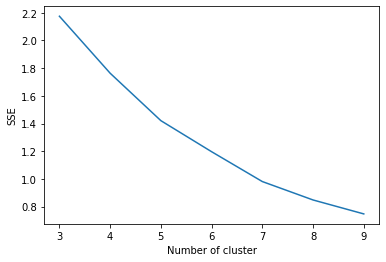

In [756]:
# Plotting the elbow curve to get the right number of clusters (limit on cluster no. from 3 to 10 because of operational reasons, it would not be feasible to run more than 10 zones in a city)
sse = {}
for k in range(3,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_ll)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [757]:
# Running k-means algo based on 7 clusters and getting the cluster mapping
kmeans = KMeans(n_clusters=7, random_state=0).fit(df_ll)
df_labels_km = pd.DataFrame(kmeans.labels_)
df_labels_km.shape

(975, 1)

In [758]:
# adding the cluster Id column to the original df
dataframe_limit = pd.concat([dataframe_limit, df_labels_km], axis=1, ignore_index=True)
dataframe_limit.columns = ['venueid','venuelat','venuelng','venuename','clusteriddbscan','clusteridkmeans']

In [759]:
my_map3 = folium.Map(location = [12.9716, 77.5946], 
                                        zoom_start = 11 )

color_list = np.array(['red','blue','green','purple','darkred','darkblue','darkgreen','cadetblue','darkpurple','lightblue','lightgreen','black'])

def plotDot(dataframe_limit):
    folium.CircleMarker(location=[dataframe_limit.venuelat,  dataframe_limit.venuelng],
                        radius=2,
                        weight=2,
                        color=color_list[dataframe_limit.clusteridkmeans]
                       ).add_to(my_map3)
    
dataframe_limit.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
my_map3.fit_bounds(my_map1.get_bounds())

my_map3